In [1]:
import os
import xml.etree.ElementTree as ET
import logging
import sys
import time
import copy
import warnings
from functools import reduce
import datetime
from typing import List

import stanfordnlp
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import numpy as np
import torch as th
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import train_reviews_path, test_reviews_path, TEST_APPENDIX, word2vec_model_path, UNKNOWN_WORD, \
                parsed_reviews_dump_path, PROGRESSBAR_COLUMNS_NUM
from src.review import get_reviews, load_reviews, dump_reviews, reviews_dump_path
from src.preprocess.spell_check import spell_check, load_checked_reviews
from src.preprocess.dep_parse import parse_reviews, load_parsed_reviews, dump_parsed_reviews
from src.polarity.classifier import PolarityClassifier
from src.utils.embedding import get_embeddings

seed = 42
np.random.seed(seed)
th.manual_seed(seed)
th.cuda.manual_seed(seed)
logging.basicConfig(level=logging.INFO)

Using backend: pytorch


In [2]:
word2vec = get_embeddings()

INFO:gensim.models.utils_any2vec:loading projection weights from /home/dmitry/Projects/absa/embeddings/tayga_upos_skipgram_300_2_2019/model.bin
INFO:gensim.models.utils_any2vec:loaded (249565, 300) matrix from /home/dmitry/Projects/absa/embeddings/tayga_upos_skipgram_300_2_2019/model.bin


In [3]:
# ___________________________Train_______________________________
train_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path)
train_sentences = [x for x in reduce(lambda x, y: x + y, train_reviews)]

# ___________________________Test________________________________
test_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path + TEST_APPENDIX)
test_sentences = [x for x in reduce(lambda x, y: x + y, test_reviews)]

INFO:root:Upload dependency trees from dump.
INFO:root:Upload dependency trees from dump.


In [4]:
splits_number = 5

num_epoch = 100
mean_train_hist = np.zeros((num_epoch,))
mean_val_hist = np.zeros((num_epoch,))
kf = KFold(n_splits=splits_number)
with tqdm(total=splits_number, ncols=PROGRESSBAR_COLUMNS_NUM, file=sys.stdout) as progress_bar:
    for train_index, val_index in kf.split(train_sentences):
        classifier = PolarityClassifier(word2vec=word2vec)
        train_hist, val_hist = classifier.fit([train_sentences[i] for i in train_index], 
                                              [train_sentences[i] for i in val_index], 
                                              num_epoch=num_epoch,
                                             verbose=False)
        mean_train_hist += np.array(train_hist)
        mean_val_hist += np.array(val_hist)
        progress_bar.update(1)
mean_train_hist = mean_train_hist / splits_number
mean_val_hist = mean_val_hist / splits_number

100%|████████████████████████████████████████████████████████████████| 5/5 [31:27<00:00, 377.45s/it]


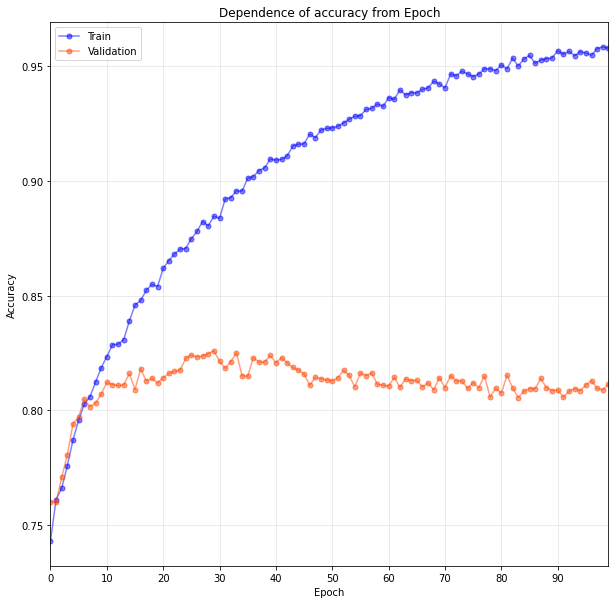

In [5]:
SCORE_NAME = 'accuracy'
PARAMETER_DECIMAL_LEN = 5
SCORE_DECIMAL_LEN = 3


def display_score(parameter_values: List,
                  train_values: List[float],
                  val_values: List[float],
                  parameter_name='Epoch',
                  score_name=SCORE_NAME) -> float:

    max_param, max_acc = [(parameter_values[index], val)
                          for index, val in enumerate(val_values) if val == max(val_values)][0]

    plt.figure(figsize=(10, 10))
    plt.grid(True, alpha=0.3)
    plt.xlim(left=min(parameter_values), right=max(parameter_values))

    # train
    plt.plot(parameter_values, train_values, color='blue', marker='o', alpha=0.5, markersize=5)
    # validation
    plt.plot(parameter_values,
             val_values,
             color='orangered',
             marker='o',
             alpha=0.5,
             markersize=5)

    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(f'Dependence of {score_name} from {parameter_name}')
    plt.xlabel(f'{parameter_name}')
    plt.ylabel(score_name.capitalize())
    if isinstance(max_param, (int, )):
        plt.legend([
            f'Maximal {score_name}={max_acc:.{SCORE_DECIMAL_LEN}} when {parameter_name}={max_param}'
        ])
    else:
        plt.legend([
            f'Maximal {score_name}={max_acc:.{SCORE_DECIMAL_LEN}}' +
            f' when {parameter_name}={max_param:.{PARAMETER_DECIMAL_LEN}f}'
        ])
    plt.legend(['Train', 'Validation'])

display_score(parameter_values=[x for x in range(num_epoch)],
              train_values=mean_train_hist,
              val_values=mean_val_hist)